# 작곡하는 AI 만들기 튜토리얼

## 패키지 다운로드

In [ ]:
!pip install torch matplotlib tqdm livelossplot gdown "pypianoroll>=1.0.2"

## 패키지 로드

In [1]:
from IPython.display import clear_output

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, BinaryTrack
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

from Networks import *
from utils import *
from config import *

os.makedirs('result', exist_ok=True)

## 학습 데이터 로드

https://salu133445.github.io/lakh-pianoroll-dataset

In [2]:
data = np.load('data/data.npz')['data']

print(data.shape)

print(data[:4][0][0])

(26154, 5, 64, 72)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


## 학습 데이터 미리보기

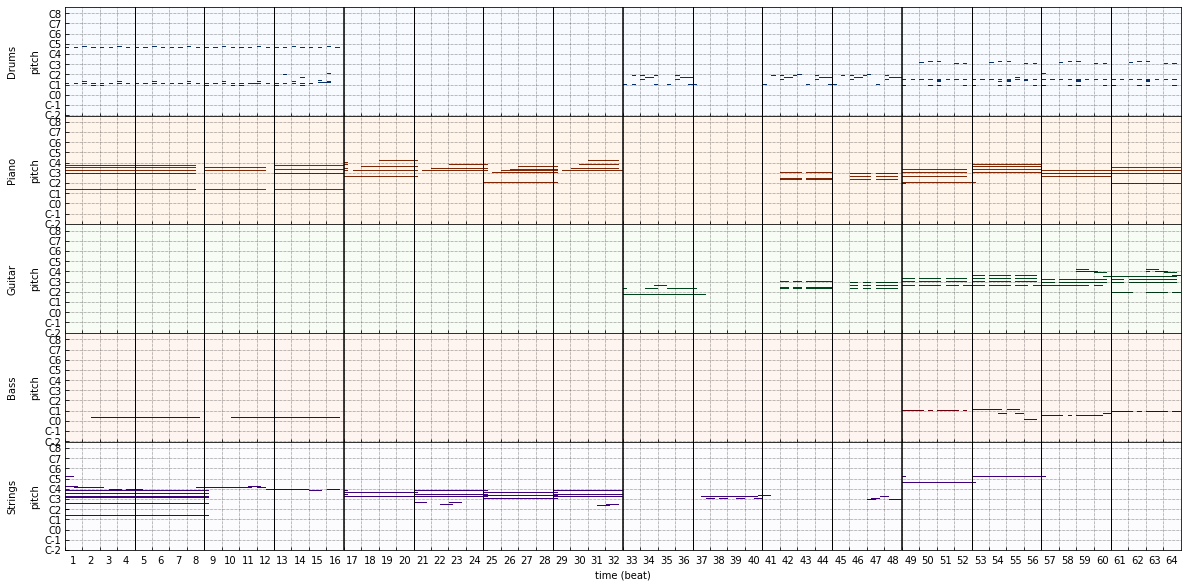

In [3]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(BinaryTrack(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((20, 10))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

## 학습 데이터 미리듣기

https://signal.vercel.app/edit

In [5]:
multitrack.write('train_sample.mid')

## Numpy -> Torch Tensor

In [6]:
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## 모델 정의하기

In [7]:
discriminator = Discriminator()
generator = Generator()

print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

Number of parameters in G: 2823343
Number of parameters in D: 204321


## 학습 유틸리티 정의

In [8]:
# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

## 학습

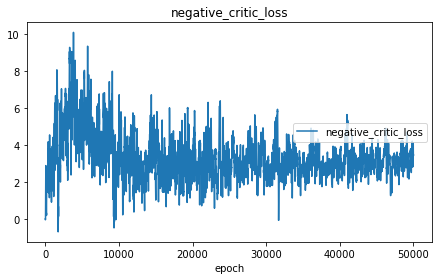

(d_loss=-3.326912, g_loss= 9.066547): 50001it [1:29:04,  9.46it/s]              

In [9]:
step = 0

# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(discriminator, generator, d_optimizer, g_optimizer, real_samples[0])

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'negative_critic_loss': -running_d_loss})
        # liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()

            # Display loss curves
            clear_output(True)
            if step > 0:
                liveloss.send()
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(
                zip(programs, is_drums, track_names)
            ):
                pianoroll = np.pad(
                    samples[idx] > 0.5,
                    ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
                )
                tracks.append(
                    BinaryTrack(
                        name=track_name,
                        program=program,
                        is_drum=is_drum,
                        pianoroll=pianoroll
                    )
                )
            m = Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=beat_resolution
            )
            
            m.write(f'result/{str(step).zfill(5)}.mid')
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

## 결과 미리보기

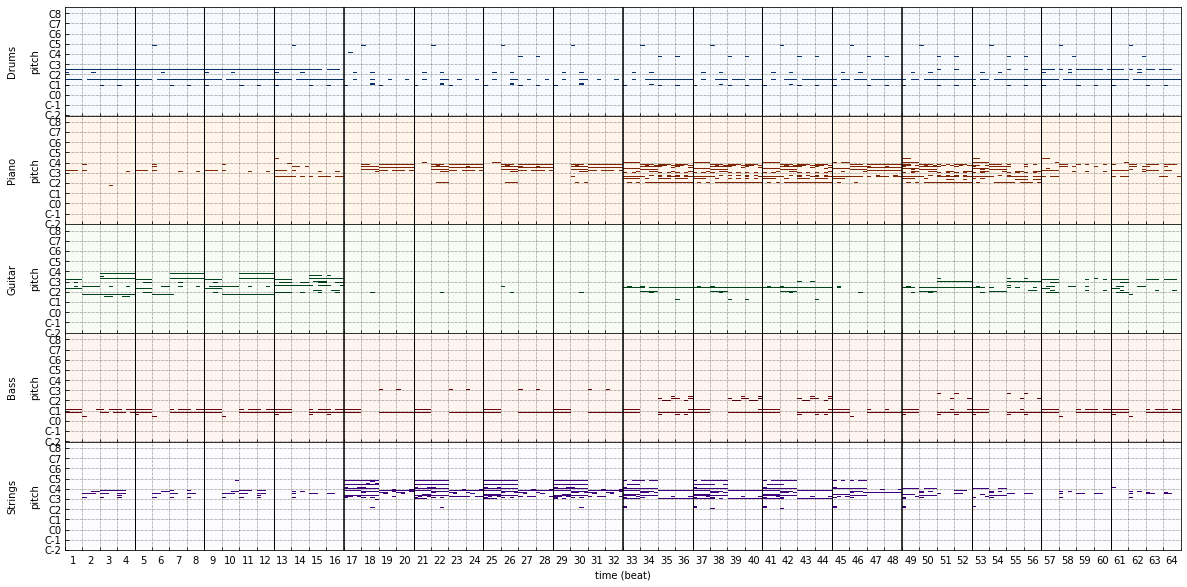

In [12]:
axs = m.plot()
plt.gcf().set_size_inches((20, 10))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()